In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,auc, roc_curve, precision_score, accuracy_score,balanced_accuracy_score,average_precision_score,f1_score,recall_score,classification_report

In [0]:
df = pd.read_csv('bank-full.csv', sep=';')

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


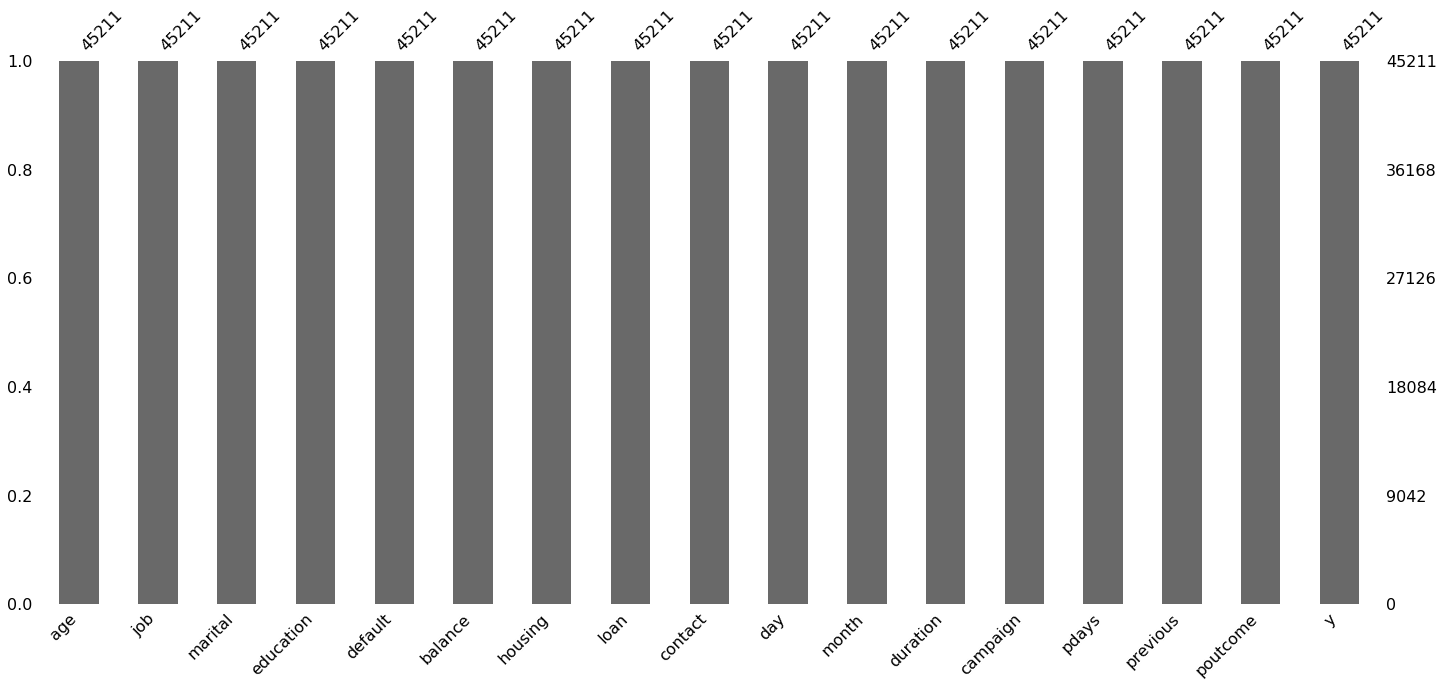

In [9]:
# Checking for missing values.

msno.bar(df)

In [10]:
# Split into predictor and response dataframes.

X_df = df.drop('y', axis=1)
y = df['y']

X_df.shape,y.shape

((45211, 16), (45211,))

In [11]:
# Map response variable to integers 0,1.

y = pd.Series(np.where(y.values == 'yes',1,0), y.index)

y.value_counts()

0    39922
1     5289
dtype: int64

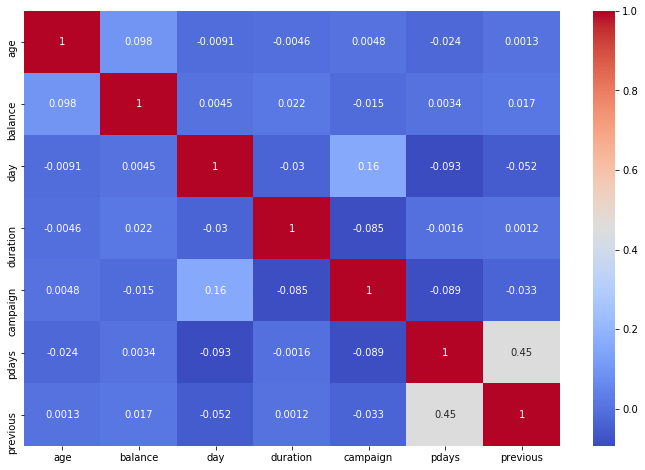

In [49]:
correlation = df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(correlation, cmap='coolwarm', annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t)
plt.show()

In [12]:
#Encoding categorical variables using DictVectorizer
#DictVectorizer is a combination of labelencoder and onehotencoder

#First we need to convert the dataframe into a dictionary
X_dict = X_df.to_dict(orient = 'records') #this is used to convert the dataframe into {column:value} format

X_dict

from sklearn.feature_extraction import DictVectorizer

dv_X = DictVectorizer(sparse = False)

X_encoded = dv_X.fit_transform(X_dict)

X_encoded

array([[5.800e+01, 2.143e+03, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [4.400e+01, 2.900e+01, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.300e+01, 2.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [7.200e+01, 5.715e+03, 5.000e+00, ..., 1.000e+00, 0.000e+00,
        3.000e+00],
       [5.700e+01, 6.680e+02, 4.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [3.700e+01, 2.971e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        1.100e+01]])

In [13]:
# Split feature and label sets to train and data sets.

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36168, 51), (9043, 51), (36168,), (9043,))

In [0]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.0min finished


In [25]:
best_clf.best_estimator_.get_params()['classifier']

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=31, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [26]:
print('Model accuracy is',best_clf.score(X_test, y_test))

Model accuracy is 0.9078845515868628


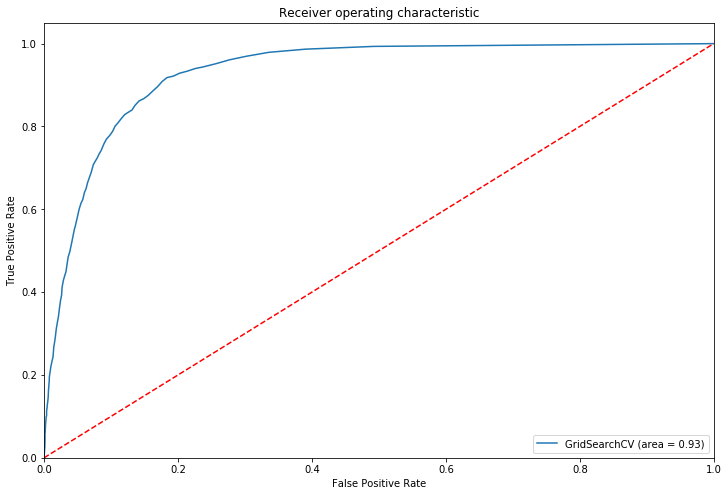

In [43]:
probs = best_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (12,8))
plt.plot(fpr, tpr, label='GridSearchCV (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [36]:
roc_auc

0.9300413107733565

In [39]:
classes = best_clf.predict(X_test)
    
accuracy = accuracy_score(classes, y_test)
    
balanced_accuracy = balanced_accuracy_score(classes, y_test)

precision = precision_score(classes, y_test)
    
average_precision = average_precision_score(classes, y_test)
    
f1_score = f1_score(classes, y_test)
    
recall = recall_score(classes, y_test)

print (accuracy, balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)

0.9078845515868628 0.7867882183823744 0.4680648236415634 0.33043614773130825 0.5410468319559228 0.6409921671018277 0.9300413107733565


In [42]:
print(classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      8277
           1       0.47      0.64      0.54       766

    accuracy                           0.91      9043
   macro avg       0.72      0.79      0.74      9043
weighted avg       0.92      0.91      0.91      9043

